# Part 1: Build a Basic Chatbot¶

#### Types of Graphs in LangGraph
- Graph: For stateless, linear workflows (no memory between steps).
- StateGraph: For stateful workflows (with memory, loops, or branches).

---

#### Concepts of Lang Graph.

- To work with langraph first we have to define its State.
- State includes the graph's Schema and reducers fuctions that handle the state.
- In our example, State is a TypedDict with one key: messages
- The add_messages reducer function is used to append new messages to the list instead of overwriting it.
- Keys without a reducer annotation will overwrite previous values.

---

##### What is State Graph.

- Stage Graph is use in LangGraph to build the stateful workflow with cycles (loops) and branches.
- Like the flowchart each step(nodes) can update the shared "memory" (state).

##### Why we have to use that.

> If we chat with AI they does not have the access of previous chats / context (AI DOES NOT STORE PREVIOUS CHATS).
1. Loop: Repeat steps until a condition is met (e.g., keep asking for input until it’s valid).
2. Branch: Choose different paths based on the current data (e.g., route a user query to "billing" or "support").
3. Remember state: Carry context between steps (e.g., track a pizza order as it’s customized).

##### Key compoenents of StateGraph.

1. State: It store the previous chats in Dictorary (eg: { "user_input" : "Hello", "step" : 1 }).
2. Nodes: A Function that take state and call **LLM** and return the updated State.
3. Edges: Rules that decide which node to run next. based on the previous State.

#### Example

1. Node 1: Ask for pizza size → updates state to {"size": "large"}.
2. Node 2: Ask for toppings → updates state to {"toppings": "cheese"}.
3. Node 3: Confirm order.
    - If user says “change size”, loop back to Node 1.
    - If confirmed, end the flow.

#### When use this.

1. Build chatbots that need context.
2. Create multi-step tools (e.g., data processing with validation loops).
3. Design any app where the next step depends on dynamic conditions.

In [1]:
from dotenv import load_dotenv

from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

load_dotenv()

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

ModuleNotFoundError: No module named 'langgraph'

In [ ]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o-mini",temperature=0.3)

def chatbot(state:State):
    messages = state["messages"]
    response = llm.invoke(messages)
    return {"messages": [response]}


- In the above we have chatbot function that take state ARGUMENT as a Input and return dictionary as output.
- That dictionary contain an updated messages list under the key "messages". This is the basic pattern of all the **LANGGRAPH** node functions 
- add_message function in our **STATE** will append the **LLM** response messages to whatever messages are already in the **STATE**. 

In [ ]:
graph_builder.add_node("chatbot", chatbot)


- This will the `entry` point. This tell the graph **where to start its work** each time we run it


In [ ]:
# graph_builder.add_edge(START,"chatbot")
graph_builder.set_entry_point("chatbot")

- This instructs the graph "**any time this node is run**, you can exit."

In [ ]:
# graph_builder.add_edge("chatbot", END)
graph_builder.set_finish_point("chatbot")

- Finally, We'll able to start the graph. To do so we, call `compile()` on the graph builder. This creates "`CompliedGraph`" we can use invoke on our State

In [ ]:
graph = graph_builder.compile()

- This is the visualization of above things.

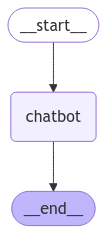

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Now let's run the bot.
- **Tip**: We can exit the chat loop by typing the `"quit" , "exit", "q"`.

In [ ]:
from langchain_core.messages import HumanMessage

def stream_graph_updates(user_input: str):
    message = HumanMessage(content=user_input)

    for events in graph.stream({"messages":[message]}):
        for value in events.values():
            if "messages" in value:
                print("Assistant:", value["messages"][-1].content)


while True:
    try:
        user_input = input("User: ")

        if user_input.lower() in ["quit","q","exit"]:
            print("Goodbye!")
            break
        print("User: " + user_input)
        stream_graph_updates(user_input)
    except:
        user_input = "What do you know about langgraph."
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: what is the capital of india.
Assistant: The capital of India is New Delhi.
User: whats its population.
Assistant: Could you please specify which location or entity you are referring to when you ask about its population?
User: 
Assistant: Hello! How can I assist you today?
Goodbye!
